<a href="https://colab.research.google.com/github/gokceuludogan/protein-ml-crash-course/blob/main/Chapter_2_Protein_Structure_Contact_Graphs_and_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 9.1 MB/s eta 0:00:00


# Chapter 2: Protein Structure - Contact Graphs and Clustering

## Overview

In this chapter, we will explore the three-dimensional (3D) structure of proteins and how to represent it using **contact graphs**. Protein structures are often analyzed by looking at how close amino acids are to each other in 3D space. A **contact graph** is a graph representation where each amino acid (node) is connected to others if they are within a certain distance (edge). We'll also apply clustering techniques to group similar regions of the protein structure.

We will:

- Parse a protein structure from a PDB file.
- Build a contact graph where nodes represent amino acids and edges represent proximity.
- Apply clustering algorithms to group the amino acids based on their positions in the structure.

---

## 1. Loading Protein Structures (PDB Files)

Protein 3D structures are stored in **PDB (Protein Data Bank)** format. The PDB file contains atomic coordinates that describe the position of each atom in space.

### Example of PDB Format:

```mathematica
mathematica
Copy code
ATOM      1  N   MET A   1      44.457  18.686  19.226  1.00  0.00           N
ATOM      2  CA  MET A   1      43.186  19.260  18.784  1.00  0.00           C
ATOM      3  C   MET A   1      42.954  18.976  17.297  1.00  0.00           C
...

```

###  Example: Loading a PDB File

We’ll use the `biopython` library to parse PDB files and extract atom coordinates.

In [10]:
from Bio.PDB import PDBParser

import requests
from io import StringIO
from Bio import PDB

def fetch_pdb_from_api(pdb_id):
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    response = requests.get(url)
    if response.status_code == 200:
        pdb_file = StringIO(response.text)
        parser = PDB.PDBParser(QUIET=True)
        structure = parser.get_structure('protein', pdb_file)
        return structure
    else:
        raise Exception(f"Failed to fetch PDB file: {response.status_code}")


def load_pdb(file_path):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('protein', file_path)
    return structure

# Example usage
# pdb_file = "example.pdb"
# structure = load_pdb(pdb_file)

# Example usage
pdb_id = "1UBQ"  # Replace with the desired PDB ID
structure = fetch_pdb_from_api(pdb_id)


## 2. Building a Contact Graph

A **contact map** represents the distances between all pairs of amino acids in a protein structure. If two amino acids are within a threshold distance (e.g., 8 Ångströms), an edge is created between them in the contact graph.

### Steps:

1. Extract the C-alpha atom coordinates (one for each amino acid).
2. Compute pairwise distances between the C-alpha atoms.
3. Build a contact map by applying a distance threshold.
4. Represent the contact map as a graph where nodes are amino acids, and edges indicate proximity.

### Example: Building the Contact Graph

In [11]:
import numpy as np
import networkx as nx
from Bio.PDB import PDBParser

def get_ca_atoms(structure):
    # Extract C-alpha atoms from the structure
    ca_atoms = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if 'CA' in residue:
                    ca_atoms.append(residue['CA'].get_coord())
    return np.array(ca_atoms)

def build_contact_graph(ca_coords, threshold=8.0):
    # Build contact graph based on distance threshold
    num_atoms = len(ca_coords)
    graph = nx.Graph()

    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):
            distance = np.linalg.norm(ca_coords[i] - ca_coords[j])
            if distance <= threshold:
                graph.add_edge(i, j)
    return graph

# Example usage
ca_atoms = get_ca_atoms(structure)
contact_graph = build_contact_graph(ca_atoms)


## 3. Visualizing the Contact Graph

We can use the **NetworkX** library to visualize the contact graph. Each node represents an amino acid, and edges represent contacts between amino acids that are close to each other.

### Example: Graph Visualization

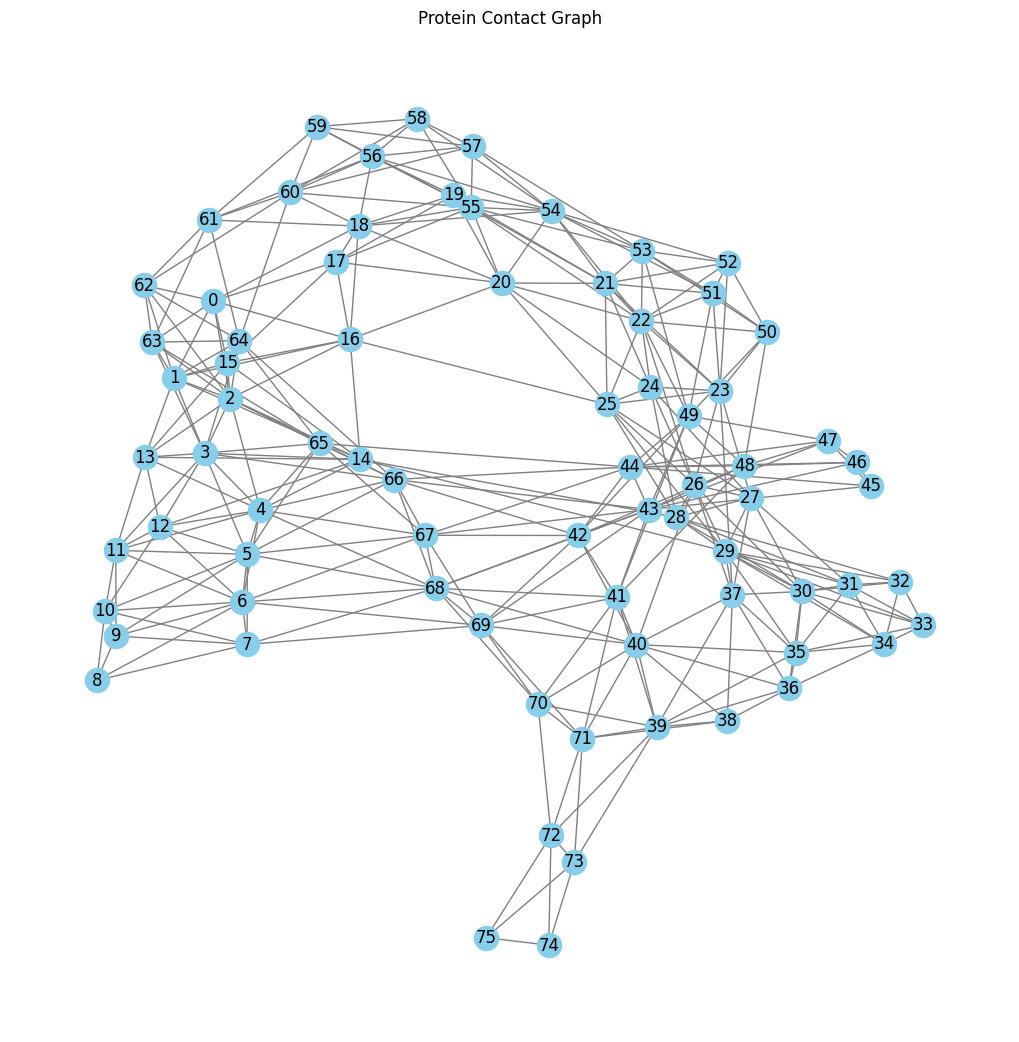

In [12]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_contact_graph(graph):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(graph)  # Layout for graph visualization
    nx.draw(graph, pos, with_labels=True, node_size=300, node_color='skyblue', edge_color='gray')
    plt.title("Protein Contact Graph")
    plt.show()

# Example usage
visualize_contact_graph(contact_graph)


## 4. Clustering Amino Acids using Graph Clustering

We can apply graph clustering algorithms to group amino acids based on their connectivity in the contact graph. This approach takes advantage of the graph structure we've already created. A popular graph clustering algorithm is the Louvain method, which optimizes modularity.

### Steps:

1. Use the contact graph as input to a graph clustering algorithm.
2. Group amino acids based on their connections in the graph.

### Clustering with Louvain Method

In [18]:
import networkx as nx
from community import community_louvain

def cluster_amino_acids(contact_graph):
    # Apply Louvain method for graph clustering
    partition = community_louvain.best_partition(contact_graph)
    return partition

# Example usage
clusters = cluster_amino_acids(contact_graph)
print("Cluster labels for each amino acid:", clusters)

Cluster labels for each amino acid: {0: 0, 1: 0, 2: 0, 15: 0, 16: 0, 17: 1, 18: 1, 62: 0, 63: 0, 3: 0, 13: 0, 14: 0, 64: 0, 4: 0, 65: 0, 66: 0, 5: 2, 11: 2, 12: 2, 6: 2, 67: 4, 68: 4, 7: 2, 9: 2, 10: 2, 8: 2, 69: 4, 28: 3, 29: 3, 20: 1, 25: 1, 19: 1, 55: 1, 54: 1, 56: 1, 60: 1, 61: 1, 21: 1, 22: 1, 24: 1, 23: 1, 51: 1, 52: 1, 53: 1, 26: 3, 49: 4, 50: 1, 27: 3, 37: 3, 30: 3, 40: 4, 31: 3, 32: 3, 33: 3, 34: 3, 35: 3, 36: 3, 39: 4, 38: 4, 71: 4, 41: 4, 70: 4, 72: 4, 73: 4, 42: 4, 43: 4, 48: 4, 44: 4, 45: 4, 46: 4, 47: 4, 57: 1, 58: 1, 59: 1, 74: 4, 75: 4}


This approach uses the graph structure to identify communities of amino acids that are more densely connected to each other than to the rest of the graph. It can reveal functional or structural modules within the protein.

## 5. Visualizing Clusters

Once the amino acids are clustered, we can visualize the clusters on the contact graph by coloring the nodes based on their cluster membership.

### Visualizing Clusters on the Contact Graph

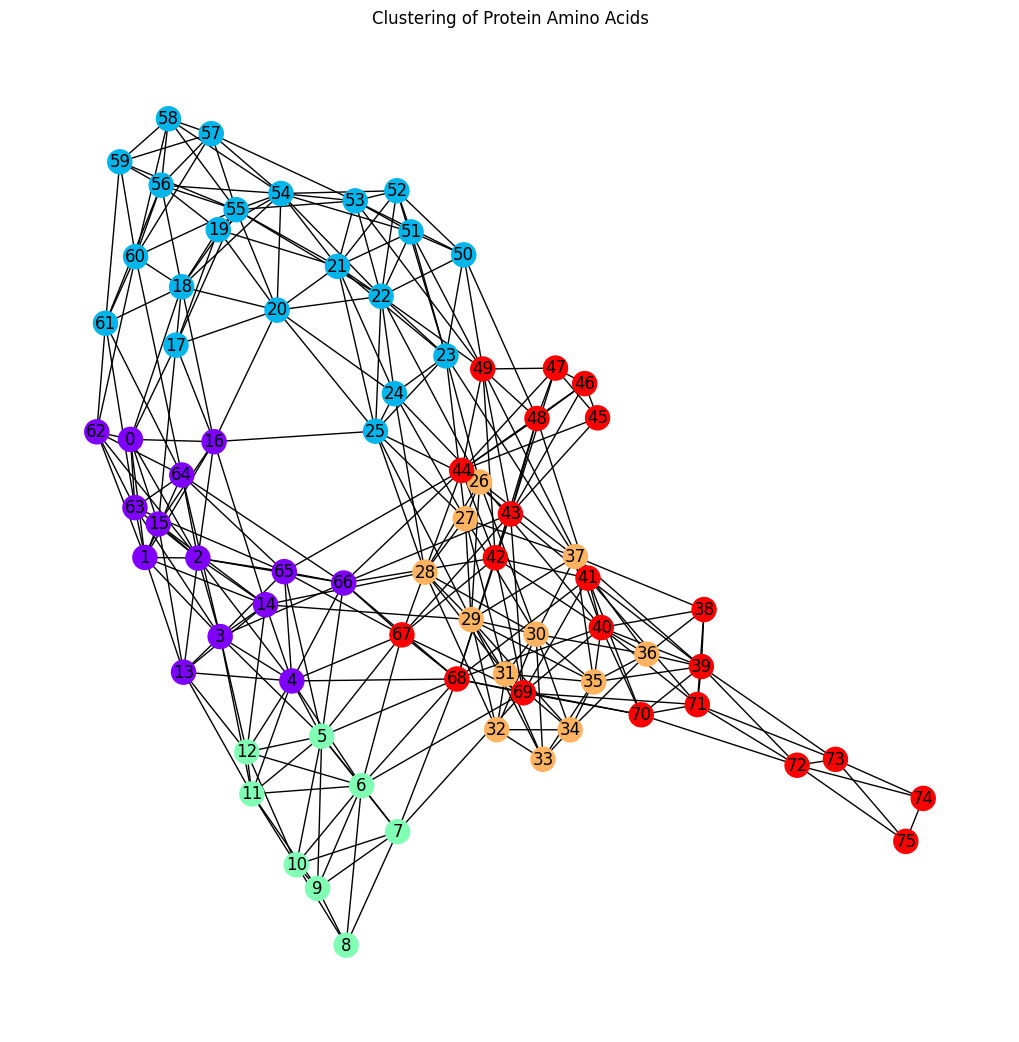

In [19]:
def visualize_clusters(graph, clusters):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(graph)
    node_colors = [clusters[node] for node in graph.nodes()]
    nx.draw(graph, pos, node_color=node_colors, with_labels=True, cmap=plt.cm.rainbow)
    plt.title("Clustering of Protein Amino Acids")
    plt.show()

# Example usage
visualize_clusters(contact_graph, clusters)

